In [97]:
import graspy
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [98]:
from graspy.simulations import sbm

n_communities = [50, 50, 50]
p = [[0.5, 0.1, 0.05],
     [0.1, 0.4, 0.15],
     [0.05, 0.15, 0.3],]

np.random.seed(2)
A = sbm(n_communities, p)
from graspy.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed()
X = ase.fit_transform(A)

In [99]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import math

In [100]:
def plt_el(data, X, j, k, means, covariances, ax, label_palette, cluster_palette, alpha):
    sns.scatterplot(data = data, x = X[:, j], y = X[:, k],  ax=ax, hue = "labels", palette = label_palette)
    means_collector = data[[j, k, "labels"]]
    means_collector = means_collector.groupby("labels").mean() 
    for i, (mean, covar) in enumerate(zip(means, covariances)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])    
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        for i, m in means_collector.iterrows():    
            if abs(float(round(mean[j],3)) - float(round(m[j],3))) < .1:
                if abs(float(round(mean[k],3)) - float(round(m[k],3))) < .1:
                    color = cluster_palette[i]
        ell = mpl.patches.Ellipse(
            [mean[j], mean[k]], v[0], v[1], 180.0 + angle, color = color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(alpha)
        ax.add_artist(ell)
        ax.set_xticks([]), ax.set_yticks([])
        ax.set_ylabel(k), ax.set_xlabel(k)

In [101]:
def graph(X, gmm, labels = None, cluster_palette = None,  label_palette = None, title = None, context="talk", font_scale=1, alpha=0.7):
    Y_, means, covariances = gmm.predict(X), gmm.means_, gmm.covariances_
    data = pd.DataFrame(data=X)
    num_comps = gmm.n_components
    if labels is None:
        data["labels"] = Y_
    else: 
        data["labels"] = labels
    data["clusters"] = Y_    
    if isinstance(cluster_palette, str) and labels is not None:
        colors = sns.color_palette(cluster_palette, num_comps)
        cluster_palette = dict(zip(np.unique(Y_), colors)) 
    if isinstance(label_palette, str) and labels is not None:
        colors = sns.color_palette(label_palette, num_comps)
        label_palette = dict(zip(np.unique(np.asarray(labels)), colors))    
    if (labels is not None) and (cluster_palette is None or label_palette is None):
        msg = "if give labels array must give palette dicts or string desciptors"
        raise ValueError(msg)
    elif labels is None and cluster_palette is None and label_palette is None:
        colors = sns.color_palette('Set1', num_comps)
        cluster_palette = dict(zip(np.unique(Y_), colors))
        label_palette = dict(zip(np.unique(Y_), colors))
    elif labels is None and (cluster_palette is not None or label_palette is not None):
        msg = "must give labels if using palettes for labels and clusters"
        raise ValueError(msg)
    with sns.plotting_context(context=context, font_scale=font_scale):
        if X.shape[1] == 2: 
            pairplot, axes = plt.subplots(1, 1, figsize=(12, 12))
            plt_el(data, X, 0, 1, means, covariances, axes, label_palette, cluster_palette, alpha = alpha)
            axes.set_ylabel("Dim " + str(0))
            axes.set_xlabel("Dim " + str(1))
            axes.label_outer()
            axes.spines["right"].set_visible(False)
            axes.spines["top"].set_visible(False)
            if title:
                pairplot.suptitle(title)
            else:
                pairplot.suptitle(
                    "Fit a Gaussian mixture using "
                    + str(means.shape[0])
                    + " components"
                )
            return 
        pairplot, axes = plt.subplots(X.shape[1], X.shape[1], figsize=(12, 12))
        for k in range(X.shape[1]):
            for j in range(X.shape[1]):
                if k == j:
                    for t, lab in (zip([i for i in range(X.shape[1])], label_palette)):
                        sns.distplot(
                            X[Y_ == t, k], kde=True, ax=axes[k, k], color = label_palette[lab]
                        )
                    axes[k, j].set_xticks([]), axes[k, j].set_yticks([])
                    axes[k, j].set_ylabel(None)
                    axes[k, j].set_ylabel(j), axes[k, j].set_xlabel(k)
                else:
                    plt_el(data, X, j, k, means, covariances, axes[k,j], label_palette, cluster_palette, alpha = alpha)
        for i in range(X.shape[1]):
            for j in range(X.shape[1]):
                axes[i, j].set_ylabel("Dim " + str(i))
                axes[i, j].set_xlabel("Dim " + str(j))
        if title:
            pairplot.suptitle(title)
        else:
            pairplot.suptitle(
                "Fit a Gaussian mixture using " + str(means.shape[0]) + " components"
            )
        handles, labels = [], []
        for ax in axes.flat:
            ax.label_outer()
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.legend().remove()
            handles_, labels_ = ax.get_legend_handles_labels()
            handles += handles_
            labels += labels_

        pairplot.legend(
            handles[: means.shape[0]], labels[: means.shape[0]], loc="upper right"
        )
                    


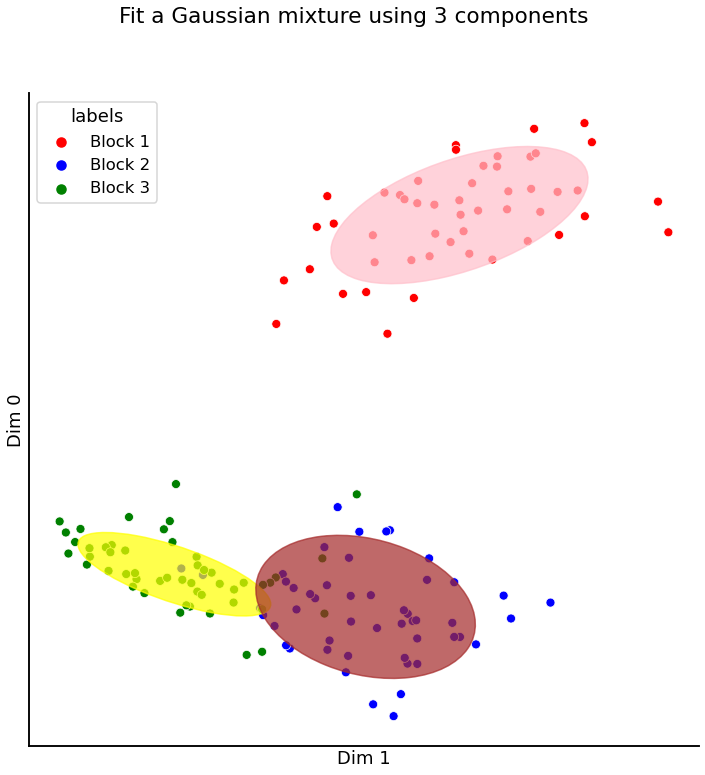

In [105]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X[:, :2])

labels = ['Block 1'] * 50 + ['Block 2'] * 50 + ['Block 3'] * 50
cluster_palette = {"Block 1": 'pink', "Block 2": 'brown', "Block 3": 'yellow'}
label_palette = {"Block 1": 'red', 'Block 2':'blue', 'Block 3': 'green'}
graph(X[:,:2], gmm, labels = labels, cluster_palette = cluster_palette,  label_palette = label_palette)
#graph(X, gmm, labels = None, cluster_palette = None,  label_palette = None)